# This notebook plots the average number of CCS comparisons for a set of regions 

## It uses CCS track statistics file and counts each unique CCS located on a 1x1 degree grid once

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from itertools import chain
import copy
%matplotlib inline

In [2]:
# Dictionary for official model names
model_name = {
    'obs': 'OBS',
    'scream': 'SCREAM',
    'mpi': 'ICON',
    'nasa': 'GEOS',
    'nicam': 'NICAM',
    'uk': 'UM',
    'noaa': 'X-SHiELD',
}

lifetime_bounds = [2,400]
sdate = '2020-02-01T00'
edate = '2020-03-01T00'

test = ''
# test = '_ccs1_2h'
rootdir = '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/'
obsdir = f'{rootdir}obs/stats{test}/monthly/'
obsfile = f'{obsdir}track_counts_gridmap_20200201_20200301.nc'

name_map = {
    'obs': 'obs',
    'm1': 'mpi',
    'm2': 'scream',
    'm3': 'nasa',
    'm4': 'nicam',
    'm5': 'noaa',
    'm6': 'uk',
}
m1dir = f'{rootdir}{name_map["m1"]}/stats{test}/monthly/'
m2dir = f'{rootdir}{name_map["m2"]}/stats{test}/monthly/'
m3dir = f'{rootdir}{name_map["m3"]}/stats{test}/monthly/'
m4dir = f'{rootdir}{name_map["m4"]}/stats{test}/monthly/'
m5dir = f'{rootdir}{name_map["m5"]}/stats{test}/monthly/'
m6dir = f'{rootdir}{name_map["m6"]}/stats{test}/monthly/'
m1file = f'{m1dir}track_counts_gridmap_20200201_20200301.nc'
m2file = f'{m2dir}track_counts_gridmap_20200201_20200301.nc'
m3file = f'{m3dir}track_counts_gridmap_20200201_20200301.nc'
m4file = f'{m4dir}track_counts_gridmap_20200201_20200301.nc'
m5file = f'{m5dir}track_counts_gridmap_20200201_20200301.nc'
m6file = f'{m6dir}track_counts_gridmap_20200201_20200301.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures{test}/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures/


In [3]:
obsfile, m1file, m2file, m3file, m4file, m5file, m6file

('/global/cfs/cdirs/m1867/zfeng/dyamond-winter/obs/stats/monthly/track_counts_gridmap_20200201_20200301.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/mpi/stats/monthly/track_counts_gridmap_20200201_20200301.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/scream/stats/monthly/track_counts_gridmap_20200201_20200301.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/nasa/stats/monthly/track_counts_gridmap_20200201_20200301.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/nicam/stats/monthly/track_counts_gridmap_20200201_20200301.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/noaa/stats/monthly/track_counts_gridmap_20200201_20200301.nc',
 '/global/cfs/cdirs/m1867/zfeng/dyamond-winter/uk/stats/monthly/track_counts_gridmap_20200201_20200301.nc')

In [4]:
# Read OBS data
dsobs = xr.open_dataset(obsfile)
dsobs

<xarray.Dataset>
Dimensions:       (time: 1, lat: 120, lon: 360, lat_bnds: 121, lon_bnds: 361)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-01
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5 59.5
  * lon           (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat_bnds      (lat_bnds) float64 -60.0 -59.0 -58.0 -57.0 ... 58.0 59.0 60.0
  * lon_bnds      (lon_bnds) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0 360.0
Data variables:
    track_counts  (time, lat, lon) float32 ...
Attributes:
    title:       Track counts on grid
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Tue Sep 27 12:11:57 2022

In [5]:
# Read m1 data
dsm1 = xr.open_dataset(m1file)

In [6]:
# Read m2 data
dsm2 = xr.open_dataset(m2file)

In [7]:
# Read m3 data
dsm3 = xr.open_dataset(m3file)

In [8]:
# Read m4 data
dsm4 = xr.open_dataset(m4file)

In [9]:
# Read m5 data
dsm5 = xr.open_dataset(m5file)

In [10]:
# Read m6 data
dsm6 = xr.open_dataset(m6file)

In [11]:
xbins = dsobs['lon_bnds']
ybins = dsobs['lat_bnds']
# Get lat/lon bin center value
lonbins = dsobs['lon']
latbins = dsobs['lat']

In [12]:
ccs_number_obs = dsobs['track_counts'].squeeze()
ccs_number_m1 = dsm1['track_counts'].squeeze()

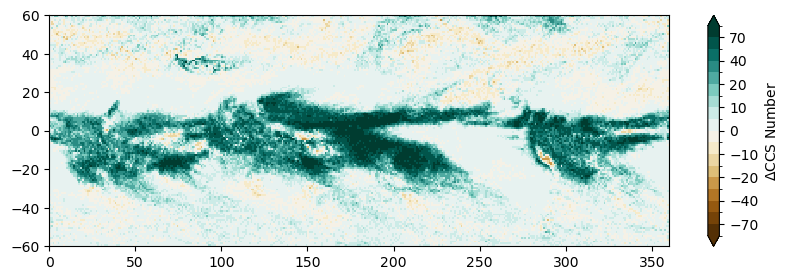

In [13]:
diff = ccs_number_m1 - ccs_number_obs
fig = plt.figure(figsize=[10,3], dpi=100)
levels = [-100,-70,-50,-40,-30,-20,-15,-10,-5,0,5,10,15,20,30,40,50,70,100]
cmap = mpl.cm.get_cmap('BrBG')
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
pcm = plt.pcolormesh(xbins, ybins, diff, norm=norm, cmap=cmap)
plt.colorbar(label='$\Delta$CCS Number', extend='both')

In [14]:
# Define boundaries for calculating regional mean
box_mc = [95,150,-20,5]
box_itcz = [151,250,0,12]
box_spcz = [151,210,-30,-1]
box_io = [50,94,-15,5]
box_afc = [10,40,-20,5]
box_amz = [-75%360,-40%360,-20,0]
box_ao = [-40%360,-10%360,-8,8]
box_amz180 = [-75,-40,-20,0]
box_ao180 = [-40,-10,-8,8]
boxes = {
    'MC':box_mc,
    'ITCZ':box_itcz,
    'SPCZ':box_spcz,
    'IO':box_io,
    'AO':box_ao,
    'AFC':box_afc,
    'AMZ':box_amz,
}

## Function to calculate regional mean

In [15]:
def calc_reg_diff(number_mod, number_obs, boxes, latbins, lonbins):
    """
    Calculate regional mean difference in number
    """
    # Calculate regional mean difference
    diff_reg = np.zeros(len(boxes), dtype=float)
    text_loc_x = np.zeros(len(boxes), dtype=float)
    # Loop over each region
    for ii, name in enumerate(boxes):
        # print(name)
        xid = np.where((lonbins >= boxes[name][0]) & (lonbins <= boxes[name][1]))[0]
        yid = np.where((latbins >= boxes[name][2]) & (latbins <= boxes[name][3]))[0]
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
        # Calculate mean difference in percentage
        val_mod = number_mod[min(yid):max(yid), min(xid):max(xid)]
        val_obs = number_obs[min(yid):max(yid), min(xid):max(xid)]
        diff_reg[ii] = 100 * (np.nansum(val_mod) - np.nansum(val_obs)) / np.nansum(val_obs)

    # Put values in dictionary
    dict_out = dict(zip(boxes.keys(), diff_reg))
    print(dict_out)
    
    return dict_out

In [16]:
print(model_name[name_map['m1']])
dict_m1 = calc_reg_diff(dsm1['track_counts'].squeeze(), dsobs['track_counts'].squeeze(),  boxes, latbins, lonbins)

ICON
{'MC': 179.8065399760315, 'ITCZ': 561.7782152230972, 'SPCZ': 302.89521138048485, 'IO': 166.69806877060762, 'AO': 277.03216879972325, 'AFC': 155.67543923598456, 'AMZ': 132.66857177600778}


In [17]:
print(model_name[name_map['m2']])
dict_m2 = calc_reg_diff(dsm2['track_counts'].squeeze(), dsobs['track_counts'].squeeze(), boxes, latbins, lonbins)

SCREAM
{'MC': 50.30816640986132, 'ITCZ': 116.51356080489938, 'SPCZ': 89.55620116209177, 'IO': 85.23316062176166, 'AO': 109.68523002421307, 'AFC': -22.395567543923597, 'AMZ': -0.9545813826229708}


In [18]:
print(model_name[name_map['m3']])
dict_m3 = calc_reg_diff(dsm3['track_counts'].squeeze(), dsobs['track_counts'].squeeze(), boxes, latbins, lonbins)

GEOS
{'MC': 24.332306111967128, 'ITCZ': 4.494750656167979, 'SPCZ': -42.16589861751152, 'IO': -13.165332077249175, 'AO': -26.66897267381529, 'AFC': 11.008237952905155, 'AMZ': 13.297257858576032}


In [19]:
print(model_name[name_map['m4']])
dict_m4 = calc_reg_diff(dsm4['track_counts'].squeeze(), dsobs['track_counts'].squeeze(), boxes, latbins, lonbins)

NICAM
{'MC': 15.164355418592706, 'ITCZ': 48.89545056867892, 'SPCZ': 0.6411540773392106, 'IO': 37.79243209295023, 'AO': 14.164648910411623, 'AFC': 11.467522052927025, 'AMZ': -11.728582720252934}


In [20]:
print(model_name[name_map['m5']])
dict_m5 = calc_reg_diff(dsm5['track_counts'].squeeze(), dsobs['track_counts'].squeeze(), boxes, latbins, lonbins)

X-SHiELD
{'MC': 36.55196028077384, 'ITCZ': 84.01137357830271, 'SPCZ': 49.4840713283911, 'IO': 28.03422829329565, 'AO': -20.771359391214112, 'AFC': -9.185682000437414, 'AMZ': 1.471392959202286}


In [21]:
print(model_name[name_map['m6']])
dict_m6 = calc_reg_diff(dsm6['track_counts'].squeeze(), dsobs['track_counts'].squeeze(), boxes, latbins, lonbins)

UM
{'MC': -16.23865776408149, 'ITCZ': -45.527121609798776, 'SPCZ': -32.03265878581447, 'IO': -43.76668236771864, 'AO': -62.08924247665168, 'AFC': -45.17751694977036, 'AMZ': -25.639934334529094}


## Plot regional mean difference as bar chart

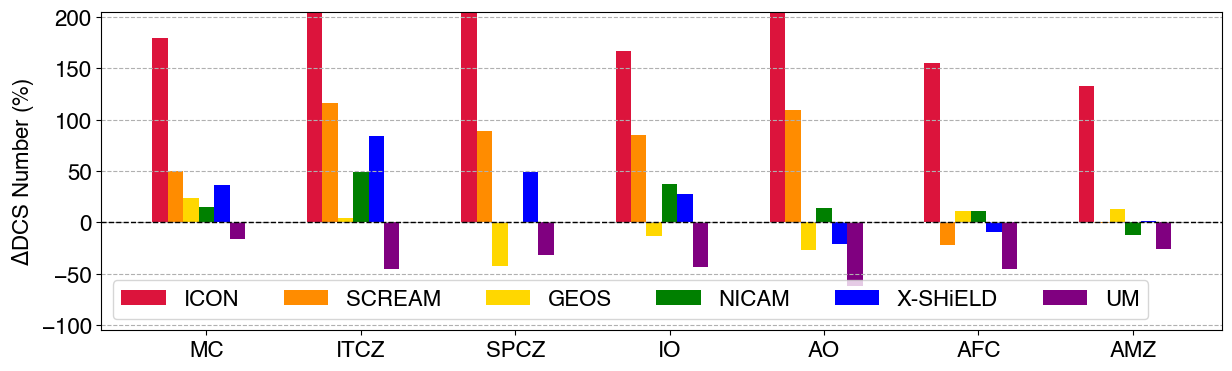

In [22]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['font.weight'] = 'regular'

labels = list(dict_m1.keys())
x = np.arange(len(labels))
width = 0.1
ylim = (-105,205)

lcolors = {
    'obs':'k', 
    'm1': 'crimson',
    'm2': 'darkorange', 
    'm3': 'gold',
    'm4': 'green',
    'm5': 'blue',
    'm6': 'purple',
}

fig, ax = plt.subplots(figsize=[13,4], dpi=100)
b_m1 = ax.bar(x - 3*width, list(dict_m1.values()), width, color=lcolors['m1'], label=model_name[name_map['m1']])
b_m2 = ax.bar(x - 2*width, list(dict_m2.values()), width, color=lcolors['m2'], label=model_name[name_map['m2']])
b_m3 = ax.bar(x - 1*width, list(dict_m3.values()), width, color=lcolors['m3'], label=model_name[name_map['m3']])
b_m4 = ax.bar(x + 0*width, list(dict_m4.values()), width, color=lcolors['m4'], label=model_name[name_map['m4']])
b_m5 = ax.bar(x + 1*width, list(dict_m5.values()), width, color=lcolors['m5'], label=model_name[name_map['m5']])
b_m6 = ax.bar(x + 2*width, list(dict_m6.values()), width, color=lcolors['m6'], label=model_name[name_map['m6']])
ax.axhline(y=0, lw=1, ls='--', color='k')
ax.grid(which='major', ls='--', axis='y')
ax.set_ylim(ylim[0], ylim[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(f'$\Delta$DCS Number (%)')
# ax.set_title('', loc='left')
ax.set_xticks(x, labels)
ax.legend(ncol=6)

# ax.bar_label(b_m1, padding=3)
fig.tight_layout()
figname = f'{figdir}globalmap_ccs_number_regional_meandiff_barchart.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

In [23]:
figname

'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures/globalmap_ccs_number_regional_meandiff_barchart.png'